In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import cv2
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

**Dataset and Preprocessing**

In [28]:
def load_dataset(path):
    X = []
    y = []
    classes = sorted(os.listdir(path))
    print("Classes found:", classes)

    for cls in classes:
        folder = os.path.join(path, cls)
        if not os.path.isdir(folder):
            continue
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (32, 32))
            img = img.flatten()
            X.append(img)
            y.append(cls)

    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {len(X)} images successfully.")
    return X, y


Classes found: ['cat', 'dog', 'panda']
Loaded 300 images successfully.
Feature array shape: (300, 1024)
Labels array shape: (300,)


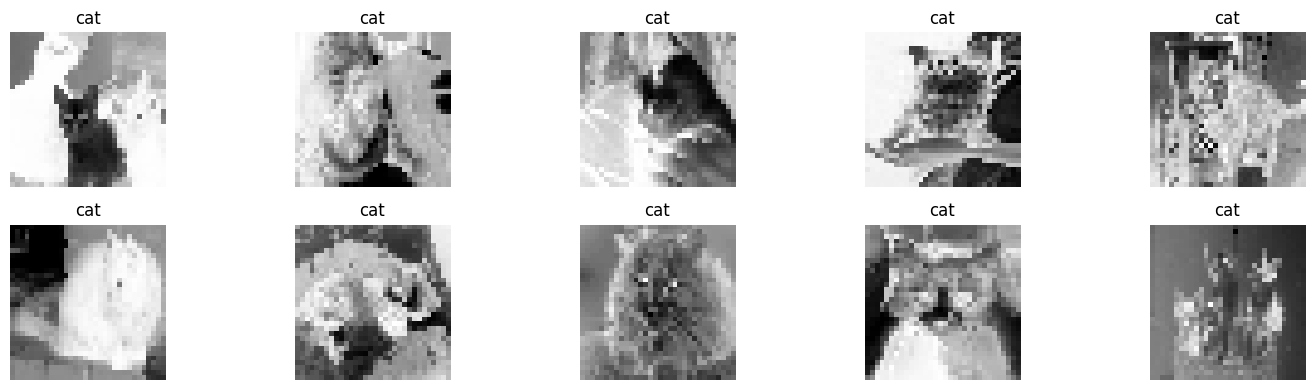

In [31]:
dataset_path = "/content/drive/My Drive/CVPR/animal_dataset"
X, y = load_dataset(dataset_path)
print("Feature array shape:", X.shape)
print("Labels array shape:", y.shape)

plt.figure(figsize=(15,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(32,32), cmap='gray_r')
    plt.title(y[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


**Model Building and Evaluation**

In [32]:
K_values = [1,3,5,7,9]
metrics = ['manhattan', 'euclidean']
results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for metric in metrics:
    avg_acc = []
    for K in K_values:
        fold_acc = []
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            knn = KNeighborsClassifier(n_neighbors=K, metric=metric)
            knn.fit(X_train, y_train)

            pred = knn.predict(X_test)
            acc = accuracy_score(y_test, pred)
            fold_acc.append(acc)

        avg_acc.append(np.mean(fold_acc))
    results[metric] = avg_acc


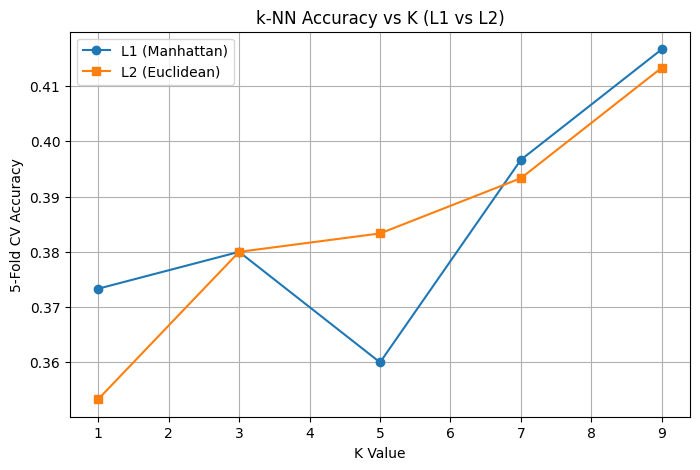

In [33]:
plt.figure(figsize=(8,5))
plt.plot(K_values, results['manhattan'], marker='o', label='L1 (Manhattan)')
plt.plot(K_values, results['euclidean'], marker='s', label='L2 (Euclidean)')
plt.xlabel("K Value")
plt.ylabel("5-Fold CV Accuracy")
plt.title("k-NN Accuracy vs K (L1 vs L2)")
plt.grid(True)
plt.legend()
plt.show()


**Results and Analysis**

In [36]:
best_metric = 'manhattan'
best_K = 3

knn = KNeighborsClassifier(n_neighbors=best_K, metric=best_metric)
knn.fit(X, y)


KNeighborsClassifier(metric='manhattan', n_neighbors=3)

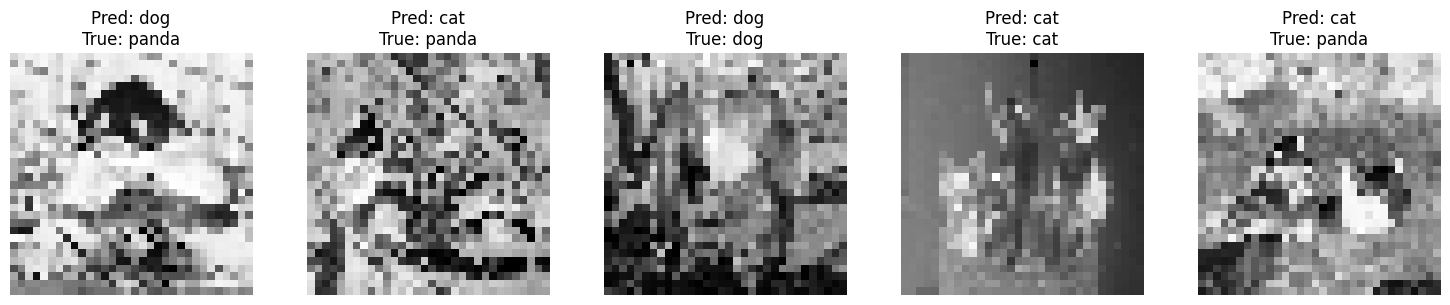

In [37]:
np.random.seed(42)
test_indices = np.random.choice(len(X), 5, replace=False)

plt.figure(figsize=(15,3))
for i, idx in enumerate(test_indices):
    test_img = X[idx]
    pred = knn.predict(test_img.reshape(1,-1))[0]

    plt.subplot(1,5,i+1)
    plt.imshow(test_img.reshape(32,32), cmap='gray_r')
    plt.title(f"Pred: {pred}\nTrue: {y[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**Discussion**


The 5-fold cross-validation revealed moderate accuracy (36-41%) for both distance metrics, with Manhattan (L1) consistently outperforming Euclidean (L2). Sample predictions showed significant confusion between similar animals (dog/cat/panda), indicating that raw 1024-pixel features lack discriminative power for gray-scale images. As raw pixel values alone cannot effectively distinguish between visually similar animal classes.